# Grid and Feature Contribution

This document shows the procedure of grid search and feature contribution investigation. 

In [112]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from treeinterpreter import treeinterpreter as ti
import matplotlib.cm as cm
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sv = survey('data/survey2/')

In [5]:
sv.num_processor()

In [6]:
df = sv.fin_data

In [7]:
dfc = df.copy()
dfc['educom'] = (dfc.paeduc+dfc.maeduc+dfc.speduc)/3        
dfc.drop(['paeduc','maeduc','speduc'], axis =1, inplace=True)
y = dfc.pop('employed').values
X = dfc.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

### 1. Fit random forest model

In [8]:
rf = RandomForestClassifier(n_jobs=-1,random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Take first 30 important features to model

In [9]:
f30 = rf.feature_importances_.argsort()[::-1][:30]
rf_redu = RandomForestClassifier(n_jobs=-1,random_state=0)
slct=dfc.columns[f30]   #selected features
X = dfc[slct].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

In [10]:
rf_redu.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## 2. Grid search

In [11]:
#1st round
# rf_grid = {'max_depth': [3, None], 
#                       'max_features': ['sqrt', 'log2', None],
#                       'min_samples_split': [1, 2, 4],
#                       'min_samples_leaf': [1, 2, 4],
#                       'bootstrap': [True, False],
#                       'n_estimators': [10, 20, 40],
#                       'random_state': [1]}

#2nd
rf_grid = {'max_depth': [None], 
           'criterion':['gini','entropy'],
                      'max_features': ['log2', None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [True, False],
                      'n_estimators': [30, 40,80],
                      'random_state': [1]}

#3rd 
rf_grid = {'max_depth': [None], 
           'criterion':['gini'],
                      'max_features': ['log2',None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [False],
                      'n_estimators': [60,80,100],
                      'random_state': [1]}
#last round
rf_grid = {'max_depth': [None], 
           'criterion':['gini'],
                      'max_features': ['log2',None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [False],
                      'n_estimators': [230,250,300],
                      'random_state': [1]}

In [12]:
rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             rf_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')

In [13]:
rf_gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   22.8s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [230, 250, 300], 'min_samples_split': [1], 'random_state': [1], 'criterion': ['gini'], 'max_features': ['log2', None], 'bootstrap': [False], 'max_depth': [None], 'min_samples_leaf': [2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc',
       verbose=True)

In [14]:
rf_gridsearch.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 1,
 'n_estimators': 300,
 'random_state': 1}

In [15]:
best_rf = rf_gridsearch.best_estimator_

roc_auc_score : 0.818305210155


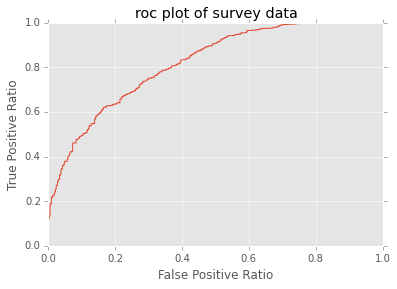

In [16]:
plot_roc(best_rf,X_test,y_test)

### 3.  Tree Interpreter and Feature Contribution

In [17]:
prediction, bias, contributions = ti.predict(best_rf, X_test)

#### make feature contribution data frame

In [37]:
fc_df = pd.DataFrame(contributions[:,:,1], columns=slct)

In [38]:
fc_df['predict'] = best_rf.predict(X_test)    # predicted result

In [39]:
fc_df['employed'] = y_test                   # true result

In [40]:
fc_df['correct'] = fc_df.predict == fc_df.employed      # check if the prediction is correct

In [41]:
fc_df.drop('predict',axis =1, inplace=True)               #subset correct instances

## 4. Clustering Feature Contribution Matrix

* pca
* kmeans on principle components

### PCA

In [42]:
fc_f_pca = fc_df.drop(['employed','correct'],axis =1)       #only pass feature columns to pca

In [43]:
pca = PCA(n_components= 10)
pca.fit(fc_f_pca.values)

PCA(copy=True, n_components=10, whiten=False)

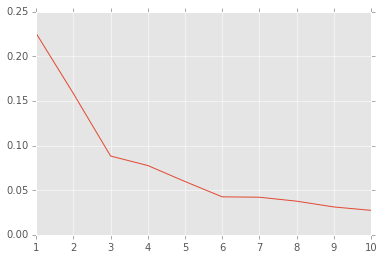

In [44]:
plt.plot(range(1,11),pca.explained_variance_ratio_)

** Three principle components will be fine **

In [45]:
pca = PCA(n_components=4)
fc_pca = pca.fit_transform(fc_f_pca.values)

### Kmeans

To determine which k for kmeans. I wrote a function to check kmeans cluster performance. 

1. Take a range of Ks and make a for loop

2. In each loop：
  * Generate k clusters using kmeans. concatinate cluster id to 'employed' and 'correct' columns, as a new data frame.
  * Group data frame by cluster id, calcuate employed rate and correct rate by taking means
  * If the employed rate is higher than 0.7 or lower than 0.3, then we can say this cluster successfull group employed or unemployed population, so this cluster yields pure population.
  * If the correct rate is higher than 0.7, we can say this cluter has high accuracy.
  * The clusters with pure population and meantime with high accuracy are ones we want. 
  * Therefore, the percentage of good clusters is calculated.
  * Print employed and correct rate of each good cluster, as well as the good cluster ratio.
  
3. plot total number of k against good cluster ratio

5 clusters
         employed   correct
cluster                    
0        0.863158  0.863158
---
1 out of 5 clusters split the target ideally. Good cluster rate: 0.2
********************
6 clusters
         employed   correct
cluster                    
1        0.305085  0.762712
2        0.864583  0.864583
---
2 out of 6 clusters split the target ideally. Good cluster rate: 0.333333333333
********************
7 clusters
         employed   correct
cluster                    
0        0.714592  0.725322
1        0.305085  0.762712
2        0.875000  0.875000
3        0.256410  0.777778
---
4 out of 7 clusters split the target ideally. Good cluster rate: 0.571428571429
********************
8 clusters
         employed   correct
cluster                    
1        0.709007  0.713626
4        0.757576  0.803030
5        0.254386  0.807018
6        0.305085  0.762712
7        0.869231  0.869231
---
5 out of 8 clusters split the target ideally. Good cluster rate: 0.625
*****************

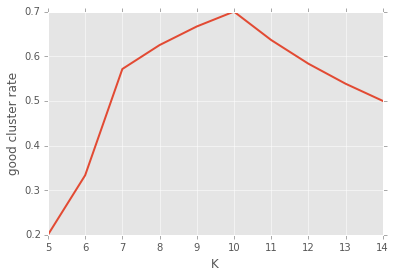

In [170]:
km_emp_mean(fc_pca,15,fc_df.employed,fc_df.correct)

According to the result, when the number of cluster is 10, good cluster ratio is the highest.  

In [183]:
km = KMeans(n_clusters=10,random_state=0)
km.fit(fc_pca)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=0, tol=0.0001,
    verbose=0)

In [184]:
fc_df['cluster'] = km.labels_

In [185]:
fc_df.groupby('cluster')['employed','correct'].agg([np.mean,np.size])

employed        correct     
             mean size      mean size
cluster                              
0        0.871486  249  0.871486  249
1        0.261261  111  0.810811  111
2        0.600000   65  0.646154   65
3        0.735099  151  0.754967  151
4        0.818182   55  0.854545   55
5        0.181818   22  0.818182   22
6        0.704918  427  0.714286  427
7        0.534884   86  0.744186   86
8        0.340206   97  0.752577   97
9        0.358974   78  0.641026   78

In [189]:
fc_df.groupby('cluster').agg([np.mean])

,coninc,age,educom,degree,sphrs1,partyid,agekdbrn,class_,dwelling,polviews,...,natroad,fechld,helpoth,parsol,chldidel,workhard,mawrkgrw,meovrwrk,employed,correct
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.044538,0.007846,0.006088,0.020328,0.017734,0.001732,0.003689,0.012218,0.001116,0.004272,...,0.001375,0.003063,0.001445,0.001670,0.001821,0.001663,0.000829,0.001026,0.871486,0.871486
1,-0.002975,-0.024710,-0.024161,0.011758,-0.044599,-0.010992,-0.008518,-0.006966,-0.007301,-0.010033,...,-0.006271,-0.008856,-0.004340,-0.005865,-0.005949,-0.003856,-0.005878,-0.005498,0.261261,0.810811
2,0.047625,0.003165,-0.002390,-0.117518,0.003392,0.001299,-0.005781,-0.004645,0.004059,-0.000498,...,0.000539,-0.000242,0.001983,0.002498,-0.002689,-0.000228,-0.000684,0.000853,0.600000,0.646154
3,-0.043331,0.001126,0.003951,0.026251,0.006255,0.003418,0.002001,0.018991,0.002855,0.001482,...,0.001147,0.003813,0.000913,0.001368,0.002348,0.001282,0.000038,0.000561,0.735099,0.754967
4,0.046685,0.004159,0.001208,0.021664,0.012205,-0.002540,-0.003899,-0.064452,-0.002820,0.004251,...,-0.000127,-0.000036,-0.000608,0.000713,0.000658,0.001044,-0.003424,-0.000519,0.818182,0.854545
5,-0.071624,-0.002385,-0.008138,-0.106335,-0.000748,-0.005279,-0.012832,-0.084109,-0.003161,-0.007878,...,-0.004069,0.000856,-0.001546,-0.005323,-0.002996,-0.006091,-0.002166,-0.000940,0.181818,0.818182
6,0.030061,0.003783,-0.001435,0.016236,-0.008468,0.001539,0.002260,0.007125,-0.000200,0.002393,...,0.000698,0.002618,0.000737,0.000746,0.001167,0.000589,0.001084,-0.000431,0.704918,0.714286
7,-0.096938,-0.011172,-0.000813,0.027381,0.003058,-0.001701,-0.005469,0.016767,-0.004319,-0.005329,...,-0.003876,-0.006361,-0.002977,-0.005831,-0.002882,-0.001770,-0.003534,-0.002655,0.534884,0.744186
